# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [1]:
import numpy as np
import sklearn.linear_model as lm
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [2]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [3]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 1, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [4]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise) # Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

Для рандомного выбора N элементов из датасета соберем все сгенерированные данные в data и сшафлим объекты, из перемешанных данных будем выбирать необходимые N объектов

In [5]:
err = []
LRs = []
data = np.concatenate((X,y,y_gt), axis=1)
for N in N_grid:
    np.random.shuffle(data)
    X_train = data[:N,0]
    y_train = data[:N,1]
    y_target = data[:,2]
    LR = lm.LinearRegression()
    LR.fit(X_train.reshape(-1,1), y_train)
    y_pred = LR.predict(data[:,0].reshape(-1,1))
    error = np.sum((y_pred - y_target) ** 2) / N
    err.append(error)
    LRs.append(LR)

Код для построения графиков:

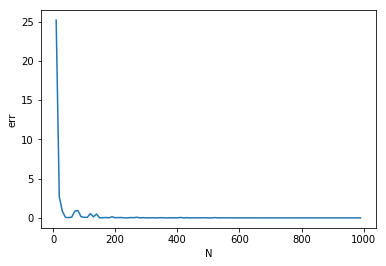

In [6]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

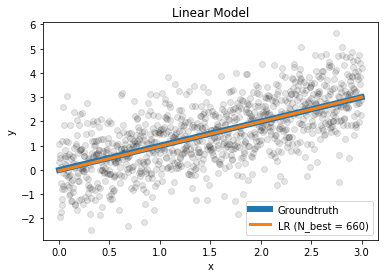

In [16]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=6)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR (N_best = {0})".format(N_grid[np.argmin(err)])], loc=4)
plt.title('Linear Model')
plt.xlabel("x")
plt.ylabel("y")
plt.show()
# seems to be perfectly predicted ¯\_(ツ)_/¯

Проделайте тоже самое для KNN при n_neighbors=3.

Видно, что при N = 660 прямая регрессии становится почти неотличимой от реальной прямой.

In [17]:
err = []
KNNs = []

for N in N_grid:
    np.random.shuffle(data)
    X_train = data[:N,0]
    y_train = data[:N,1]
    y_target = data[:,2]
    neigh = KNeighborsRegressor(n_neighbors=3)
    neigh.fit(X_train.reshape(-1,1), y_train)
    y_pred = neigh.predict(data[:,0].reshape(-1,1))
    error = np.sum((y_pred - y_target) ** 2) / N
    err.append(error)
    KNNs.append(LR)

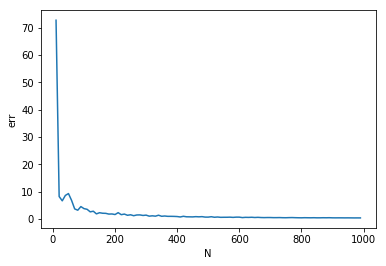

In [18]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

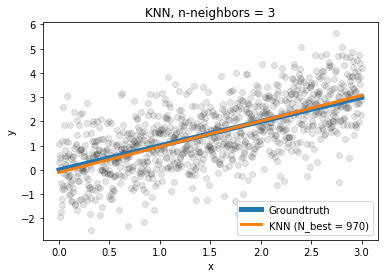

In [19]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=5)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN (N_best = {0})".format(N_grid[np.argmin(err)])], loc=4)
plt.title('KNN, n-neighbors = 3')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличте число соседей до 10 и проделайте тоже самое.

In [20]:
err = []
KNNs = []

for N in N_grid:
    np.random.shuffle(data)
    X_train = data[:N,0]
    y_train = data[:N,1]
    y_target = data[:,2]
    neigh = KNeighborsRegressor(n_neighbors=10)
    neigh.fit(X_train.reshape(-1,1), y_train)
    y_pred = neigh.predict(data[:,0].reshape(-1,1))
    error = np.sum((y_pred - y_target) ** 2) / N
    err.append(error)
    KNNs.append(LR)

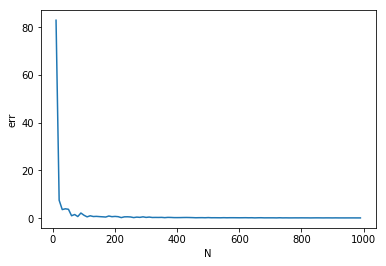

In [21]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

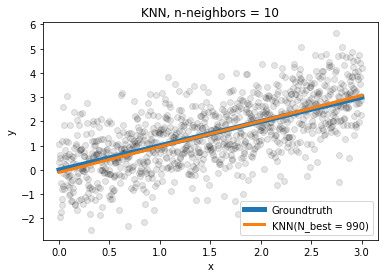

In [23]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=5)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN(N_best = {0})".format(N_grid[np.argmin(err)])], loc=4)
plt.title('KNN, n-neighbors = 10')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

Линейная модель:
При обучении на выборке из N < 100 MSE большая и уменьшается при увеличении N неравномерно, при 100 < N < 1000 MSE стремится к нулю, а prediction модели с минимальной ошибкой хорошо аппроксимирует исходную функцию y_gt, что отображено на графике 'Linear Model'

KNN: 
Очевидно, при маленькой выборке (N мало) обучающей ошибка MSE может быть очень большой, но при увеличении N ошибка уменьшается равномерно (без скачков). Причем при N < 200 и n_neighbors = 10 ошибки меньше, чем при n_neighbors = 3, что можно заметить, сравнив графики 'KNN, n-neighbors = 10' и 'KNN, n-neighbors = 3'

В целом, линейная модель и метод к ближайших соседей - базовые методы, выбор которых для задачи регрессии обуславливается размером выборки и другими аспектами.

#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        pp.PolynomialFeatures(degree=d_new)
        X_new = pp.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

In [24]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [30]:
err_1 = []
LRs_1 = []
data1 = np.concatenate((X,y,y_gt), axis=1)
for N in N_grid:
    np.random.shuffle(data1)
    X_train = data1[:N,0]
    y_train = data1[:N,1]
    y_target = data1[:,2]
    LR = lm.LinearRegression()
    LR.fit(X_train.reshape(-1,1), y_train)
    y_pred = LR.predict(data1[:,0].reshape(-1,1))
    error = np.sum((y_pred - y_target) ** 2) / N
    err_1.append(error)
    LRs_1.append(LR)

err_2 = []
LRs_2 = []
poly = pp.PolynomialFeatures(degree=2)
X_new_2 = poly.fit_transform(X)
data2 = np.concatenate((X_new_2,y,y_gt), axis=1)
for N in N_grid:
    np.random.shuffle(data2)
    X_train = data2[:N,:3]
    y_train = data2[:N,3]
    y_target = data2[:,4]
    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(data2[:,:3])
    error = np.sum((y_pred - y_target) ** 2) / N
    err_2.append(error)
    LRs_2.append(LR)

err_3 = []
LRs_3 = []
poly = pp.PolynomialFeatures(degree=5)
X_new_3 = poly.fit_transform(X)
data3 = np.concatenate((X_new_3,y,y_gt), axis=1)
for N in N_grid:
    np.random.shuffle(data3)
    X_train = data3[:N,:6]
    y_train = data3[:N,6]
    y_target = data3[:,7]
    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(data3[:,:6])
    error = np.sum((y_pred - y_target) ** 2) / N
    err_3.append(error)
    LRs_3.append(LR)

In [ ]:
Код для построения всех графиков:

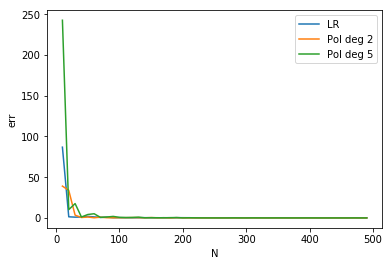

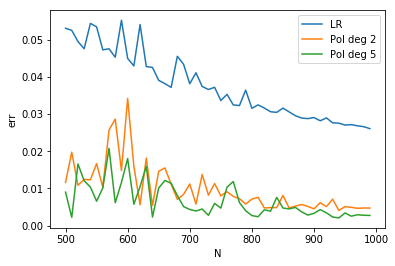

In [31]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

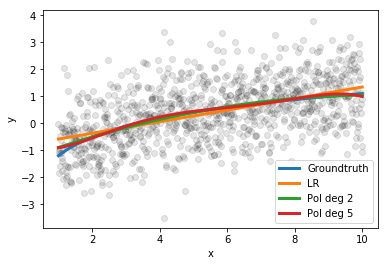

In [167]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

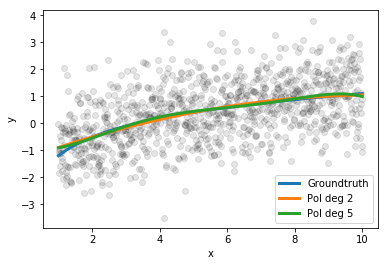

In [168]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Заметим, что модели с новыми признаками дают бОльшую ошибку на маленьких N (N < 50), но MSE заметно уменьшается при N > 500 (0.01 < error < 0.03 при 500 < N < 700 и error < 0.01 при N > 700, причем степени признаков так же влияют, в данном эксперименте degree = 2 дает более хороший результат. Все кривые довольно хорошо приближают данные, но, пожалуй кривые моделей с полиномиальными признаками дают более точную аппроксимацию.

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [169]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [170]:
LR = lm.LinearRegression()
LR.fit(X, y)
y_pred_LR = LR.predict(X)

ridge = lm.Ridge()
ridge.fit(X, y)
y_pred_Ridge = ridge.predict(X)

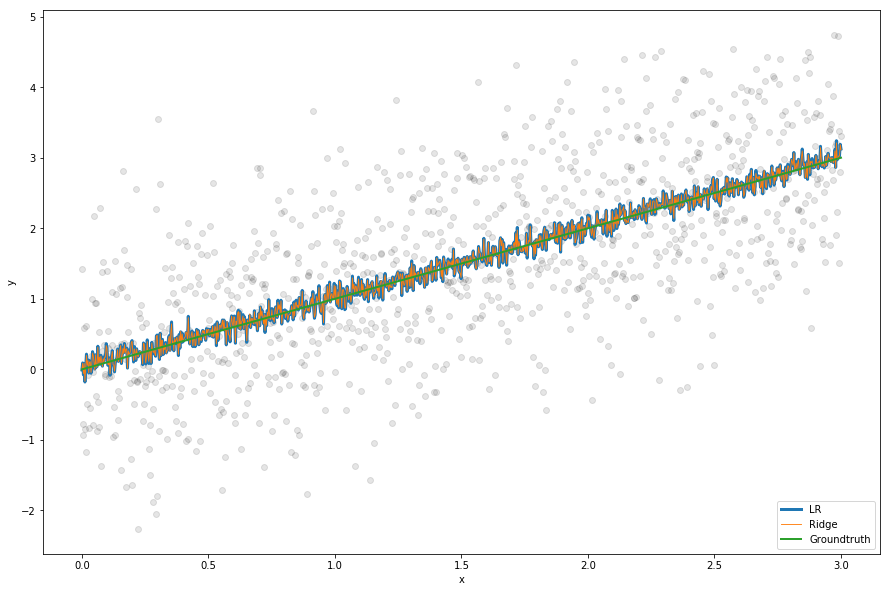

In [192]:
plt.figure(figsize=(15,10))
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=0.9)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

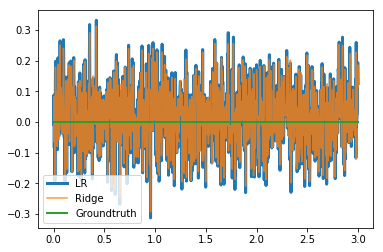

In [200]:
plt.plot(X[:,0], y_pred_LR - y_gt, linewidth = 3)
plt.plot(X[:,0], y_pred_Ridge - y_gt, alpha = 0.8)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [201]:
print(np.sum((y_pred_LR - y_gt)**2))
print(np.sum((y_pred_Ridge - y_gt)**2))

10.8741066559
9.39903979597


In [203]:
print(LR.coef_)
print(ridge.coef_)

[[-0.57356231  0.55652023  0.15203154]]
[[-0.33983345  0.44026333  0.15186287]]


Из формулы функционала Ridge регрессии 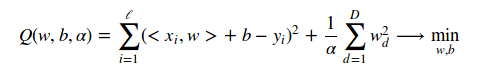
следует, что тот самый добавочный term зависит от весов (ridge.coef_), минимизируя функционал, мы минимизируем сумму квадратов весов, поэтому модель ridge регрессии дает меньшие веса по сравнению с обычной линейной регрессией. Ridge регрессия в данном случае применима, потмоу что изначально в признаках была линейна зависимость.Также, как известно, большие веса ведут к переобучению, поэтому в данном случае ridge regression оказывается полезнее. 

#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [204]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [207]:
lasso = lm.Lasso()
lasso.fit(X, y)
y_pred_lasso = lasso.predict(X)
ridge.fit(X,y)
y_pred_ridge = ridge.predict(X)

In [208]:
print(lasso.coef_)
print(ridge.coef_)

[ 0.          0.          0.14718908  0.09583764]
[[ 0.96400579  1.20879426  0.02905901 -0.12368014]]


Как видно, Lasso зануляет коэффициенты при признаках, которые нам "не нужны" (размерность данных уменьшается), то есть позволяет достигнуть интерпретируемость - отбираются признаки, оказывающие наибольшее влияние на вектор ответов. Посмотрим на формулу 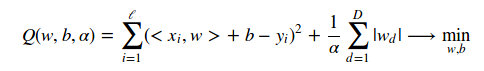
В зависимости от параметра alpha меняется число коэф-тов, принимающий нулевое значение. В данном эксперименте модель с Lasso зануляет коэф-ты при признаках x1, x2, в то время как ridge регрессия делает prediction для выборки со всеми признаками.

## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [34]:
import pandas as pd

In [86]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [87]:
data = data.iloc[:,5:]
data

,5,6,7,8,9,10,11,12,13,14,...,118,119,120,121,122,123,124,125,126,127
0,0.19,0.33,0.02,0.90,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.20,0.06,0.04,0.90,0.5,0.32,0.14,0.20
1,0.00,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,0.00,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,0.04,0.77,1.00,0.08,0.12,0.10,0.51,0.50,0.34,0.21,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03
5,0.02,0.28,0.06,0.54,1.00,0.25,0.31,0.48,0.27,0.37,...,0.01,0.58,0.10,NaN,NaN,NaN,NaN,0.00,NaN,0.14
6,0.01,0.39,0.00,0.98,0.06,0.02,0.30,0.37,0.23,0.60,...,0.05,0.08,0.06,NaN,NaN,NaN,NaN,0.00,NaN,0.03
7,0.01,0.74,0.03,0.46,0.20,1.00,0.52,0.55,0.36,0.35,...,0.01,0.33,0.00,NaN,NaN,NaN,NaN,0.00,NaN,0.55
8,0.03,0.34,0.20,0.84,0.02,0.00,0.38,0.45,0.28,0.48,...,0.04,0.17,0.04,NaN,NaN,NaN,NaN,0.00,NaN,0.53
9,0.01,0.40,0.06,0.87,0.30,0.03,0.90,0.82,0.80,0.39,...,0.00,0.47,0.11,NaN,NaN,NaN,NaN,0.00,NaN,0.15


#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Для визуализации можно использовать seaborn.heatmap()

In [39]:
corrs = data.corr(method='pearson')

In [7]:
import seaborn as sns

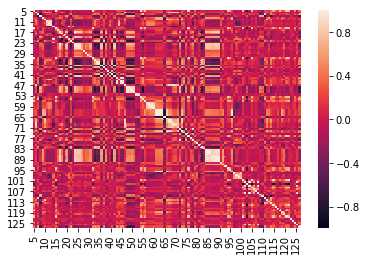

In [8]:
sns.heatmap(corrs)

У sklearn.LinearRegression под капотом испольуется аналитическая формула с обратной матрицей - точное решение, но мб долго. Сть в том, что в матрице Х с сильно коррелирующими признаками будут большие собственные значение, а у обратной матрицы (так как сз обратной матрицы это 1/сз матрицы Х) будут сз стремиться к нулю. Такое "шатание" приведет к росту коэффициентов. Для борьбы с таким явлением и существует регуляризация. 

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

In [54]:
max_corr_ind = ((corrs.iloc[:-1,:])[127]).argmax()
min_corr_ind = ((corrs.iloc[:-1,:])[127]).argmin()

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

Text(0.5,1,'With max correlation')

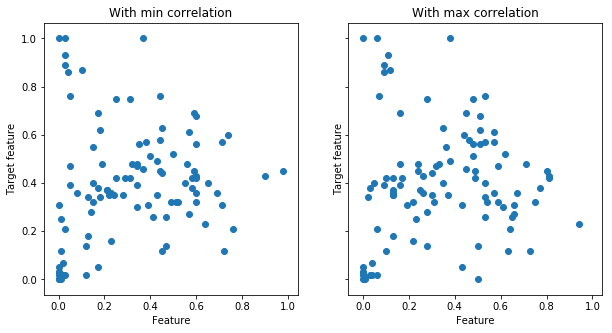

In [71]:
fig, axis = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10,5))
axis[0].scatter(data.iloc[min_corr_ind,:], data.iloc[127])
axis[0].set_xlabel('Feature')
axis[0].set_ylabel('Target feature')
axis[0].set_title('With min correlation')
axis[1].scatter(data.iloc[max_corr_ind,:], data.iloc[127])
axis[1].set_xlabel('Feature')
axis[1].set_ylabel('Target feature')
axis[1].set_title('With max correlation')

#### 3. Постройте гистограмму распределения предсказываемого значения.

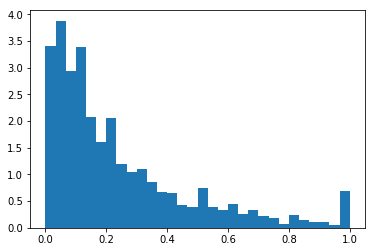

In [37]:
plt.hist(data[127], bins=30, normed=True)
plt.show()

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [88]:
for feature in data.columns:
    data[feature] = data[feature].fillna(data[feature].mean())

Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество:

In [89]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [90]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [91]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [44]:
LR = lm.LinearRegression()
LR.fit(X_train_new, y_train_new)
y_pred = LR.predict(X_test)
N = len(y_test)
error = np.sum((y_pred - y_test) ** 2) / N
print(error)

0.017997520353740703


#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [47]:
from sklearn.model_selection import GridSearchCV

For Ridge Regression

In [124]:
ridge = lm.Ridge()
alphas = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 2, 5, 10, 20]
best_ridge = GridSearchCV(ridge, {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 2, 5, 10, 20]})
best_ridge.fit(X_validate, y_validate)
ridge_alpha = best_ridge.best_params_['alpha']
print("Best params:", best_ridge.best_params_)
print("Best cross validaton score", best_ridge.best_score_)

Best params: {'alpha': 5}
Best cross validaton score 0.602248647965


For Lasso

In [135]:
lasso = lm.Lasso()
best_lasso = GridSearchCV(lasso, {'alpha':[1e-15, 1e-10, 1e-8, 1e-5,1e-4, 1e-3,1e-2,1e-1, 1, 2, 5, 10]})
best_lasso.fit(X_validate, y_validate)
lasso_alpha = best_lasso.best_params_['alpha']
print("Best params:", best_lasso.best_params_)
print("Best cross validaton score", best_lasso.best_score_)

Best params: {'alpha': 0.001}
Best cross validaton score 0.60534934533


Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

In [137]:
lasso = lm.Lasso(alpha=lasso_alpha)
lasso.fit(X_train_new,y_train_new)
ridge = lm.Ridge(alpha=ridge_alpha)
ridge.fit(X_train_new,y_train_new)
print("Lasso weights:", lasso.coef_)
print("Ridge weights:", ridge.coef_)

Lasso weights: [ 0.         -0.          0.07198087 -0.1198646  -0.          0.         -0.
 -0.         -0.02140306  0.          0.          0.02437213 -0.
 -0.01945704  0.         -0.0237104   0.          0.         -0.         -0.
  0.          0.         -0.         -0.          0.0050514   0.01129686
  0.          0.         -0.          0.          0.         -0.          0.
 -0.         -0.00366007 -0.          0.         -0.          0.13576719
  0.          0.          0.         -0.         -0.         -0.18940186
 -0.04179752 -0.         -0.         -0.03954026  0.          0.24618027
  0.          0.         -0.         -0.         -0.          0.          0.
  0.          0.         -0.          0.          0.          0.         -0.
 -0.          0.         -0.          0.07137431  0.         -0.00123229
  0.0938386  -0.0305348  -0.          0.01278114 -0.         -0.          0.
 -0.          0.          0.          0.         -0.          0.          0.
  0.          0.

Главное отличие в том, что при использовании Lasso появляется значительное число зануленных коэф-тов (так работает лассо - выбирает самые релевантные признаки, коэф-ты при других зануляются, так называемое свойство sparsity)

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

In [138]:
X_test_sparsed = X_test.iloc[:,lasso.coef_ != 0]
y_test_sparsed = y_test.iloc[lasso.coef_ != 0]

X_train_sparsed = X_train.iloc[:,lasso.coef_ != 0]
y_train_sparsed = y_train.iloc[lasso.coef_ != 0]

# lasso.fit(X_train_sparsed, y_train_sparsed)
# ridge.fit(X_train_sparsed, y_train_sparsed)

N = len(y_test)
error_lasso = np.sum((best_lasso.predict(X_test) - y_test) ** 2) / N
error_ridge = np.sum((best_ridge.predict(X_test) - y_test) ** 2) / N
print("Ridge error: {0}; Lasso error: {1}" .format(error_ridge, error_lasso))

Ridge error: 0.017371728760401942; Lasso error: 0.01725292757868022


#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [140]:
KNN = KNeighborsRegressor(n_neighbors=5)
KNN.fit(X_train_new, y_train_new)
y_pred = KNN.predict(X_test)
y_pred, y_test
N = len(y_test)
error = np.sum((y_pred - y_test) ** 2) / N
print("MSE: ",error)

MSE:  0.020029807228915675


#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [145]:
KNN = KNeighborsRegressor()
best_KNN = GridSearchCV(KNN, {'n_neighbors':[3,5,7,10,15,20,25], 'p':[1,2,3]})
best_KNN.fit(X_validate, y_validate)
best_n_neighbors = best_KNN.best_params_['n_neighbors']
best_p = best_KNN.best_params_['p']
print("Best params:", best_KNN.best_params_)
print("Best cross validaton score", best_KNN.best_score_)

Best params: {'n_neighbors': 10, 'p': 2}
Best cross validaton score 0.523353416327


С помощью какого алгоритма удалось достичь лучшего качества?

Так как использовалась метрика Минковского, а наилучшим параметром был выбран p = 2 - в итоге мы имеем Евклидову метрику с k = 10 ближайших соседей.

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

В исходном датасете изначально были признаки, которые не несли какую-либо важную роль, что удалось выявить с помощью Lasso Regression, которая при обучении выдала нулевые коэф-ты для тех самых неинформативных признаков. Для исследования датасета были получены три выборки - для обучения, валидации параметров разных регрессий, для проверки. Были использованы LinearRegression, LassoRegression, RidgeRegression, KNN и подобраны оптимальные параметры для этих методов. С помощью такой оценки качества обучения, как MSE, можно было заметить, что разные регрессии дают примерно одинаковый результат. Но так как, в датасете было значительное число неинформативных признаков, Lasso становиится наиболее привлекательным методом для данного датасета.

### Бонусная часть

За выполнение указанного ниже задания вам могут быть начислены дополнительные баллы свыше максимальных 10.

##### Реализуйте свмостоятельно функцию, которая будет перебирать значения гиперпараметра по линейной сетке 

Процесс обучения модели будет состоять из двух этапов.

Сначала для каждого значения гиперпараметра из заранее заданной сетки мы обучим регрессию на выборке (X_train, y_train) и проверим качество её работы на выборке (X_validate, y_validate). Сохранив полученные значения, среди всех перебранных значений гиперпараметра выберем такое, на котором достигается наименьшая ошибка на выборке (X_validate, y_validate).

После этого мы фиксируем значение гиперпараметра, и обучаем итоговый алгоритм на выборке, полученной объединением из X_train и X_validate . Тем самым мы сможем добиться лучшей настройки параметров регресси.

В конце концов, для тестирования качества работы нашей модели, мы проверяем её на тестовой выборке (X_test, y_test). Ошибка на этой выборке позволяет нам судить об обобщающей способности нашей модели, т.к. она не участвовала ни в одном этапе обучения. Обобщающая способность -- оценка того, насколько хорошо модель регрессии будет работать на новых данных.

In [93]:
def optimizer(X_train, y_train, X_validate, y_validate, 
              alpha_min, alpha_max, RegressionClass):
    alpha_grid = np.linspace(alpha_min, alpha_max, 100)
    err = []
    for alpha0 in alpha_grid:
        regressor = RegressionClass(alpha=alpha0)
        regressor.fit(X_train, y_train)
        err.append(np.sum((regressor.predict(X_validate) - y_validate) ** 2) / len(y_validate))
    
    alpha = alpha_grid[np.argmin(err)]
    
    
    
    #alpha_grid - массив перебираемых значений гиперпараметра
    #alpha - найденное оптимальное значение гиперпараметра 
    #err - массив среднеквадратичных отклонений для каждого из alpha_grid
    
    return alpha, err, alpha_grid

Пример вызова:
        
        alpha, err, alpha_grid = optimiser(X_train, y_train, 
                                           X_validate, y_validate,
                                           alpha_min, alpha_max,
                                           lm.Ridge)

От вас требуется применить линейную регрессию, а также Ridge и Lasso регрессию, получив оптимальные значения для alpha при помощи функции optimizer, и сравнить полученные среднеквадратичные отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

Для того чтобы понять, какие значения alpha для регрессий Ridge и Lasso являются оптимальными, вам нужно подобрать параметры alpha_min и alpha_max так, чтобы на графиках зависимости ошибки err от alpha был виден отчётливый минимум. Код для построения графиков указан ниже.

Обучите регрессии на выборке (X_train_new, y_train_new)
Какая из трёх регрессий работает лучше? Какая хуже? Почему?

Сделайте вызов функции optimizer для Ridge регрессии на выборках (X_train, y_train), (X_validate, y_validate), воспользовавшись примером её запуска. Получите оптимальное alpha, подобрав параметры alpha_min, alpha_max, как указано в задании. Обучите регрессию на выборке (X_train_new, y_train_new) с полученным параметром alpha, который передаётся при инициализации класса, например:

    lm.Ridge(alpha=my_alpha)
    
и сохраните ответы на тестовой выборке X_test в переменную y_pred

Классическая регрессия, Ридж и Лассо регрессии были уже обучены ранее на выборках (X_train_new, y_train_new), показали примерно одинаковый результат, но Лассо все-таки стала более предпочтительной, так как в исходном датасете было много признаков, не являющихся показательными, их лассо и занулила (коэф-ты при них)

In [116]:
alpha_min, alpha_max = 1e-10, 150

In [117]:
alpha, err, alpha_grid = optimizer(X_train, y_train, X_validate, y_validate, alpha_min, alpha_max, lm.Ridge)


In [118]:
ridge = lm.Ridge(alpha=alpha)
ridge.fit(X_train_new, y_train_new)
y_pred = ridge.predict(X_test)

In [119]:
print(np.mean((y_pred - y_test)**2))
print((data.mean()).iloc[-1])

0.02041592890601173
0.23797893681


Код для построения графиков ошибки на валидационной выборке в зависимости от alpha:

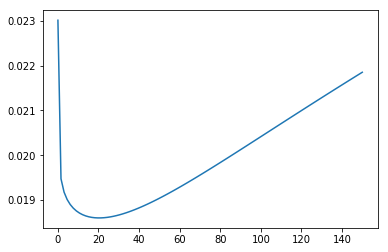

In [120]:
plt.plot(alpha_grid, err)
plt.show()

Аналогично части задания для регресии Ridge, сделайте вызов функции optimizer для регрессии Lasso, обучите её с оптимальным alpha на выборке (X_train_new, y_train_new) и сохраните предсказания для X_test в y_pred

In [145]:
alpha_min, alpha_max = 1e-20, 1e-2

In [146]:
alpha, err, alpha_grid = optimizer(X_train, y_train, X_validate, y_validate, alpha_min, alpha_max, lm.Lasso)

In [147]:
lasso = lm.Lasso(alpha=alpha)
lasso.fit(X_train_new, y_train_new)
y_pred = lasso.predict(X_test)

print(np.mean((y_pred - y_test)**2))
print((data.mean()).iloc[-1])

0.02027430214809713
0.23797893681


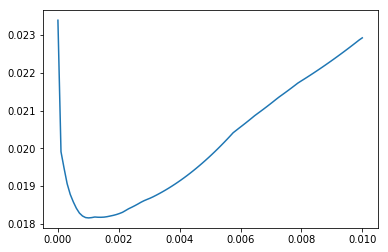

In [148]:
plt.plot(alpha_grid, err)
plt.show()

In [156]:
X_train_shrinked = X_train_new[:,lasso.coef_ != 0]
X_validate_shrinked = X_validate.iloc[:,lasso.coef_ != 0]

#### Бонусная часть 2

Ещё одним способом построения новых признаков по выборке (помимо полиномиальных преобразований) являются так называемые приближения ядер RBF (Radial Basis Function Kernel Approximations). Данный метод используется широко и везде, так как позволяет проводить в данных регрессионные кривые, вообще говоря, практически произвольной сложности. Суть его заключается в том, что он производит некоторое нелинейное преобразование признаков, которое призвано приближать абстрактное пространство бесконечной размерности. Если размерность пространства бесконечна, то в нём можно посредством линейной регрессии провести произвольную разделяющую поверхность -- в этом суть мощности данного метода.

У метода существуют два настраиваемых параметра: gamma и n_components. Для объяснения значения первого параметра потребуется подключать достаточно сложную линейную алгебру или привлекать понятие ядровой функции, что мы делать сейчас не будем. Смысл второго параметра -- количество получаемых признаков. Т.к. пространство, которое мы пытаемся приблизить, бесконечной размерности, то, вообще говоря, в n_components можно поставить любое число. Чем больше оно будет, тем лучше наши новые данные будут приближать абстрактное пространство. Данные параметры в любом случае следует лишь перебирать по сетке и выбирать те, на которых меньше всего ошибка. Для того чтобы перебор не оказался слишком большим, положим n_components равным размеру выборки, и будем настраивать лишь gamma. В предложенной задаче это не критично.

Ниже приведён код, который уже знакомым вам по функции optimizer образом переберёт по сетке гиперпараметры используемых методов: параметр gamma для RBF, и параметр alpha для Ridge регрессии. Перебор будем осуществлять по всем возможным комбинациям gamma и alpha, выбрав комбинацию с наименьшей ошибкой на валидационной выборке. Обратите внимание, что обучаться мы будем именно по подвыборке признаков, полученных вами в предыдущем задании, т.е. исключая из данных большую часть данных. Интересно, что из этого выйдет?

In [157]:
from sklearn import kernel_approximation as ka

alpha_grid = np.linspace(0.001, 1, 10)
gamma_grid = np.linspace(0.001, 1, 10)

min_err = +np.inf
for alpha in alpha_grid:
    for gamma in gamma_grid:
        RBF = ka.RBFSampler(gamma=gamma, n_components=X_train.shape[0])
        X_train_rbf = RBF.fit_transform(X_train_shrinked)
        X_validate_rbf = RBF.transform(X_validate_shrinked)
        Ridge = lm.Ridge(alpha=alpha)
        Ridge.fit(X_train_rbf, y_train)
        y_pred = Ridge.predict(X_validate_rbf)
        err = np.mean((y_pred - y_validate)**2)
        if err < min_err:
            min_err = err
            alpha_best = alpha
            gamma_best = gamma

ValueError: Found input variables with inconsistent numbers of samples: [1330, 665]

Выполнив код выше, вы получили две переменные alpha_best и gamma_best с оптимальными значениями гиперпараметров. От вас потребуется обучить на выборке (X_train_new_shrinked, y_train_new) преобразование RBF с параметром gamma_best (параметр n_components заполните так, как указано в примере ниже), а потом обучить на полученных признаках Ridge регрессию с полученным alpha_best и сравнить получившуюся ошибку с ошибой всех предыдущих методов. Какой эффект вы заметили?

Для обучения преобразования RBF вам потребуется сначала преобразовать обучающую выборку с помощью метода fit_transform (в вашем случае X_train_new_shrinked), а потом применить обученное преобразование к тестовой выборке (X_test_shrinked)

    RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
    X_train = RBF.fit_transform(X_train)
    X_test = RBF.transform(X_test)

Ниже запишите вызов класса RBF, получите новые признаки для обучающей и тестовой выборки. Постройте Ridge регрессию по выборке (X_train_new_shrinked, y_train_new), найде предсказания для тестовой X_test_shrinked, поместите их в переменную y_pred.

In [ ]:
pass # Place your code here

print(np.mean((y_pred - y_test)**2))
print(data.mean()[-1])